In [21]:
# Market Risk Model with fat tails (Student t-distribution)

This project applies a Mandelbrot-inspired approach to market risk estimation using real historical data from Ford Motor Company.

Building on the idea that financial returns exhibit fat tails and non-Gaussian behavior, this model simulates 1,000 daily returns using a Student's t-distribution with low degrees of freedom (df = 3), reflecting the presence of extreme events more frequently than a normal distribution would suggest.

The script calculates two key risk metrics:

- Value at Risk (VaR) at 95% confidence level: the threshold return below which the worst 5% of outcomes lie.
- Conditional Value at Risk (CVaR): the average of those worst-case returns, providing a more complete picture of tail risk.

Using exponential compounding, simulated returns are translated into a hypothetical price series. A histogram then visualizes the fat-tailed distribution, highlighting the contrast between VaR and CVaR.

This model offers a more realistic alternative to traditional Gaussian-based risk methods, aligning with Mandelbrot’s view of financial markets as wild, turbulent systems.

In [22]:
# Libraries

# yfinance library will be used to extract the data

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

In [24]:
#  Download Ford historical data from Yahoo Finance portal (ticker: F).

data = yf.download("F", period="5y") # 5 years of daily data

[*********************100%***********************]  1 of 1 completed


In [25]:
data.head(5)

Price,Close,High,Low,Open,Volume
Ticker,F,F,F,F,F
Date,,,,,
2020-04-13,4.072185,4.285264,3.961699,4.285264,99320000
2020-04-14,4.174778,4.293155,4.072184,4.158994,74877000
2020-04-15,3.969591,4.056401,3.906456,3.993267,74727700
2020-04-16,3.898564,4.001158,3.859105,3.993266,58951200
2020-04-17,4.040617,4.166887,3.969591,4.080077,91989300


In [26]:
data.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,F,F,F,F,F
Date,,,,,
2025-04-04,9.58,9.73,9.20,9.32,177466200
2025-04-07,9.24,9.64,9.00,9.27,274938500
2025-04-08,8.69,9.52,8.55,9.52,199286800
2025-04-09,9.50,9.54,8.44,8.50,199663000
2025-04-10,9.14,9.28,8.88,9.10,163409900


In [27]:
# The dataframe has a multiindex

In [28]:
# Flatten MultiIndex

In [29]:
data.columns = data.columns.get_level_values(0)

In [30]:
data.head(5)

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-04-13,4.072185,4.285264,3.961699,4.285264,99320000
2020-04-14,4.174778,4.293155,4.072184,4.158994,74877000
2020-04-15,3.969591,4.056401,3.906456,3.993267,74727700
2020-04-16,3.898564,4.001158,3.859105,3.993266,58951200
2020-04-17,4.040617,4.166887,3.969591,4.080077,91989300


In [31]:
# Calculate and create 'Return' column.

In [32]:
data['Return'] = data['Close'].pct_change().dropna()

In [33]:
data.columns.values

array(['Close', 'High', 'Low', 'Open', 'Volume', 'Return'], dtype=object)

In [35]:
# Take the last 1000 daily returns
returns = data['Return'].dropna().tail(1000)

In [36]:
# Fit a Student t-distribution to the returns
# Fix df=3. Low degree of freedom to reflect fat tails (as in the Mandelbrot model)
df_est = 3

In [37]:
# Standard deviation of real returns
scale = returns.std()

In [38]:
print(scale)

0.02577361911728287


In [39]:
# Average of real returns
loc = returns.mean()

In [40]:
print(loc)

0.0002903728845176998


In [41]:
# Simulate returns with t-distribution (fat tails)
sim_returns = t.rvs(df=df_est, loc=loc, scale=scale, size=1000)

In [42]:
# Convert to simulated prices
price_0 = data['Close'].iloc[-1]  # Current price as base
prices = price_0 * np.exp(np.cumsum(sim_returns)) # compound growth

In [43]:
# Create DataFrame
df_sim = pd.DataFrame({
    'Simulated_Return': sim_returns,
    'Simulated_Price': prices
})

In [46]:
df_sim.head(7)

,Simulated_Return,Simulated_Price
0,-0.018876,8.969089
1,0.009352,9.053364
2,0.064472,9.656276
3,-0.067064,9.029923
4,-0.015452,8.891463
5,-0.055754,8.409293
6,0.003240,8.436585


In [47]:
# Calculate VaR and CVaR 95%
confidence_level = 0.95
var_threshold = np.percentile(sim_returns, 100 * (1 - confidence_level)) # 5% Percentile
VaR_95 = -var_threshold # Value at risk

In [48]:
# CVaR (Expected Shortfall)
tail_losses = sim_returns[sim_returns < var_threshold] # Extreme losses
CVaR_95 = -np.mean(tail_losses) # Average of those losses

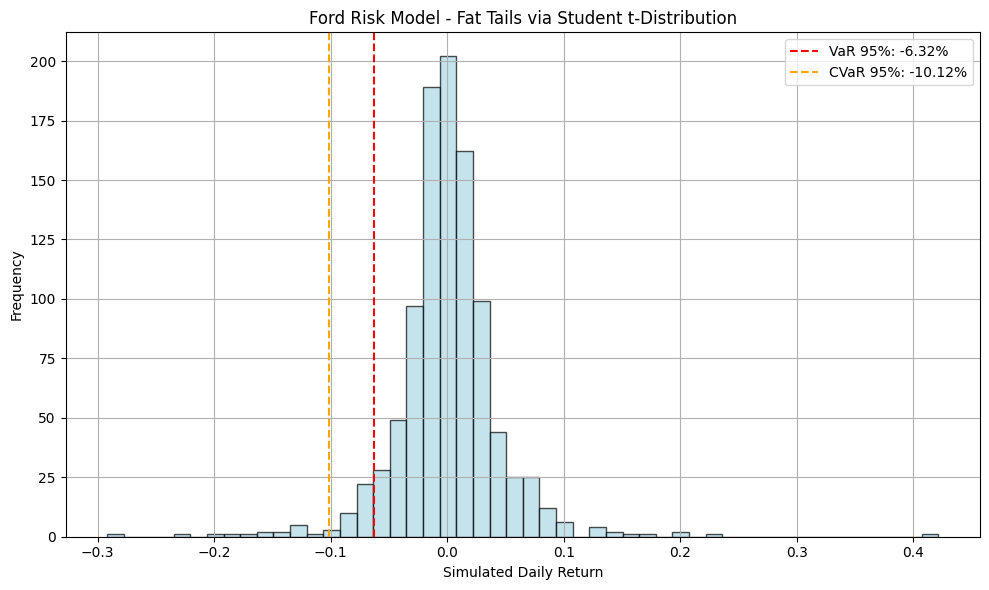

In [49]:
# Visualization

plt.figure(figsize=(10, 6))
plt.hist(sim_returns, bins=50, color='lightblue', edgecolor='black', alpha=0.7)
plt.axvline(var_threshold, color='red', linestyle='--', label=f'VaR 95%: {var_threshold:.2%}')
plt.axvline(tail_losses.mean(), color='orange', linestyle='--', label=f'CVaR 95%: {tail_losses.mean():.2%}')
plt.title('Ford Risk Model - Fat Tails via Student t-Distribution')
plt.xlabel('Simulated Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# Results.

print(f"Value at Risk (VaR) 95%: {VaR_95:.4f}")
print(f"Expected Shortfall (CVaR) 95%: {CVaR_95:.4f}")

Value at Risk (VaR) 95%: 0.0632
Expected Shortfall (CVaR) 95%: 0.1012


**Risk Analysis Conclusion**

The results obtained show that:

The 95% Value at Risk (VaR) is 6.32%, indicating that, on the 5% of worst simulated days, the daily loss for Ford stock could exceed this percentage. The Expected Shortfall (CVaR), which represents the average of the most extreme losses, amounts to 10,12%. This gap between VaR and CVaR confirms the presence of fat tails in the distribution of simulated returns and shows that, when exceptional losses occur, they tend to be significantly more severe than the VaR threshold.

In line with the ideas of Benoît Mandelbrot, this analysis demonstrates that methods based on normal distributions can underestimate the true risk of financial markets. The use of a Student's t-distribution with low degrees of freedom better captures this extreme behavior, providing a more robust and realistic risk assessment.

